##Functions

In [ ]:
from torch.cuda import device_of
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import time

def set_general_params(n_0 = 1, p_s = 1, B = 4, K = 4, P = 4, N = 2, L = 2,
                       T = 5,epochs=15, J=10,X_is_variable = False,
                       W_is_phase_only = True, W_is_block_diag = True,
                       train_size = 1500, batch_size = 20, pga_iters=400,
                       optimizer_learning_rate=0.03):
    """
    This function sets the general parameters of the network.
     used in order to save space in the code when running multiple simulations.
    :param n_0: noise power
    :param p_s: signal power
    :param B: number of frequency bins
    :param K: number of users to be served
    :param P: number of panels in the base station
    :param N: number of antennas in each panel
    :param L: number of outputs in each panel
    :param T: number of inputs to the CPU
    :param epochs: number of epochs in the training
    :param J: number of iteration to be unfolded , usually 10.
    :param X_is_variable: if True, X is a variable in the network. usually False.
    :param W_is_phase_only: if True, W is a phase matrix. usually True.
    :param W_is_block_diag: if True, W is a block diagonal matrix. usually True.
    :param train_size: number of samples in the training set.
    :param batch_size: batch size in the training part.
    :param pga_iters: number of iterations in the PGA algorithm to be compared with. in order of 300-400.
    :param optimizer_learning_rate: learning rate of the optimizer. denoted as eta in the paper.
    :return: all the parameters.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    M = P * N  # Total number of antennas in the Base station
    snr = p_s / n_0
    T_opt = max(math.floor(M * (K - L) / K + 1), K)  # minimal number of inputs to the CPU that allows loss-less processing. as described in "Trade-Offs in Decentralized Multi-Antenna Architectures: The WAX Decomposition".
    if T==5: # build the A matrix using the example given in "Trade-Offs in Decentralized Multi-Antenna Architectures: The WAX Decomposition"
        A = torch.empty((L * P, T))
        A[:T, :] = torch.eye(T)
        A[T:, :3] = torch.eye(3)
        A[T:, 3:] = 1
        A = A.to(dtype=torch.cfloat).to(device)
    if T == 61: # build the A matrix using the example given in "Trade-Offs in Decentralized Multi-Antenna Architectures: The WAX Decomposition"
        #Make sure that L*P = 100
        A = torch.empty((100, 61))
        A[ :61, :] = torch.eye(61)
        A[61:, :39] = torch.eye(39)
        A[61:83, 39:] = torch.eye(22)
        A[83:, 39:56] = torch.eye(17)
        A[83:88, 56:] = torch.eye(5)
        A[88:93, 56:] = torch.eye(5)
        A[93:98, 56:] = torch.eye(5)
        A[98:, 56:58] = torch.eye(2)
        A[98:, 58:60] = torch.eye(2)
        A = A.to(dtype=torch.cfloat).to(device)
    Ik = torch.eye(T, dtype=torch.cfloat).to(device)
    Im = torch.eye(M, dtype=torch.cfloat).to(device)
    D = torch.zeros((M, L * P)).to(device)
    for p in range(P):
        p_n, p_l = p * N, p * L
        D[p_n:(p_n + N), p_l:(p_l + L)] = torch.ones((N, L))
    return device, n_0, p_s, B, K, P, N, M, L, T, snr, T_opt, A, Ik, Im, D,J, epochs, W_is_block_diag, W_is_phase_only, X_is_variable, train_size, batch_size, pga_iters, optimizer_learning_rate


def gen_data(seed = 43, train_size = 1500, batch_size = 20, valid_size = 250):
    device = torch.device('cpu')  # generating all samples on the CPU for consistency
    torch.manual_seed(seed)
    H_train = torch.randn((train_size, B, M, K), dtype=torch.cfloat, device=device) # creating H_train in an i.i.d. manner
    H_valid = torch.randn((valid_size, B, M, K), dtype=torch.cfloat, device=device) # creating H_valid in an i.i.d. manner
    X = torch.eye(T, dtype=torch.cfloat)
    W = torch.randn((M, L*P), dtype=torch.cfloat)

    return H_train, H_valid, X, W


def project_onto_block_diagonal(w,D):
    """
    This function projects the matrix w onto the block diagonal matrix D.
    :param w: the matrix to be projected
    :param D: a predefined block diagonal matrix consisting of ones and zeros.
    :return: the projection of w onto a block diagonal matrix.
    """
    return w * D


def project_onto_phases(w):
    """
    This function projects the matrix w onto the phases of w. after projection, all entries of W has a unit magnitude.
    :param w: the matrix to be projected
    """
    W_phases = torch.exp(1j * torch.angle(w))
    return W_phases


class UnfoldedModel(nn.Module):
    """
    Building the unfolded model. in our code, this model is used as a skeleton for the Unfolded + Momentum algorithm.
    Significantly outperforms the PGA algorithm.
    Reaches almost the same performance as the Unfolded + Momentum algorithm.
    """

    def __init__(self, Mu_W, Mu_X, J):
        super().__init__()
        self.Mu_W = Mu_W
        self.Mu_X = Mu_X
        self.J = J
        self.D = D


    def forward(self, H, W, X, A, p_s, n_0):
        """
        This function describes the flow of the unfolded model. Here, the values of Mu_W vary in each iteration.
        :param H: a matrix of size BxMxK containing the channel realizations for each frequency bin.
        :param W: the inital value of W. usually randomized. It is important not to take a scaled identity matrix as the initial value of W, since it harms the convergence of the algorithm.
        :param X: the inital value of X. set to be identity matrix.
        :param A: the initial value of A. predefined in the set_genral_params function.
        :return: the list of rates obtained in each iteration, the the final value of W and X.
        """
        W_1 = W.detach()
        X_1 = X.detach()
        Rs = torch.zeros(self.J, dtype=torch.cfloat).to(device)
        # project W onto constraints:
        if W_is_phase_only:
            W_1 = project_onto_phases(W_1)
        if W_is_block_diag:
            W_1 = project_onto_block_diagonal(W_1, self.D)
        # starting the iterations:
        for j in range(self.J):
            dR_dW = self.calc_dR_dW(H, W_1, X_1, A, p_s, n_0)
            W_1 = W_1 + self.Mu_W[j] * dR_dW # making a gradient step
            if X_is_variable:
                dR_dX = self.calc_dR_dX(H, W_1, X_1, A, p_s, n_0)
                X_1 = X_1 + self.Mu_X[j] * dR_dX
            if W_is_phase_only: # projecting W onto constraints
                W_1 = project_onto_phases(W_1)
            if W_is_block_diag:
                W_1 = project_onto_block_diagonal(W_1,self.D)
            Rs[j] = self.calc_R(H, W_1, X_1, A, p_s, n_0)
        return Rs, W_1, X_1


    def calc_R(self, H, W, X, A, p_s, n_0):
        """gets a channel realization H and returns the achievable rate of it. H is of dimension (B,M,K)"""
        R = 0
        B, M, K = H.shape
        G = W @ A @ X
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            R += torch.log((Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()).det())
        return R/B


    def calc_max_r(self, H):
        """calclulates the maximal rate of the channel H, susbstituting G to be the matched filter. not used in the algorithm"""
        R = 0
        B, M, K = H.shape
        G = H # the matched filter is obtained when G = H^H
        snr = p_s / n_0
        for b in range(B): # iterating over each frequency bin
            h1 = H[b, :, :]
            g1 = G[b, :, :]
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            R += torch.log((Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()).det())
        return R/B # averaging over the frequency bins


    def calc_dR_dW(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to W. the gradient has the same dimension as W"""
        grad = 0
        for b in range(B): #iterating over each frequency bin
            h1 = H[b, :, :]
            snr = p_s / n_0
            X_con = X.conj()
            W_con = W.conj()
            H_con = h1.conj()
            G = W @ A @ X
            G_herm = G.transpose(0, 1).conj()
            h1_herm = h1.transpose(0, 1).conj()
            G_psu_inv = torch.inverse(G_herm @ G)
            Proj_mat = G @ G_psu_inv @ G_herm
            Z = snr * G_psu_inv @ G_herm @ h1 @ h1_herm @ G
            dR_dZ = torch.inverse(Ik + Z)
            grad += snr * (
                        (A @ X) @ dR_dZ @ (2 * G_psu_inv @ G_herm) @ h1 @ h1_herm @ (Im - Proj_mat)).conj().transpose(0,                                                                                                       1)
        return grad / B # averaging over the frequency bins


    def calc_dR_dX(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to X. the gradient has the same dimension as X"""
        """ not used in our code! """
        snr = p_s / n_0
        X_con = X.conj()
        W_con = W.conj()
        H_con = H.conj()
        G = W @ A @ X
        G_herm = G.transpose(0, 1).conj()
        H_herm = H.transpose(1, 2).conj()
        G_psu_inv = torch.inverse(G_herm @ G)
        Proj_mat = G @ G_psu_inv @ G_herm
        Z = snr * G_psu_inv @ G_herm @ H @ H_herm @ G
        dR_dZ = torch.inverse(Ik + Z)
        return snr * (dR_dZ @ (2 * G_psu_inv @ G_herm) @ H @ H_herm @ (Im - Proj_mat) @ W @ A).conj().transpose(1, 2)


    def batch_rate(self, batch, W, X, A, p_s, n_0):
        """ Used in order to calculate the average rate of a batch. Calling the forward functon for each sample in the batch"""
        batch_rate = 0
        for sample_num in range(batch.shape[0]):
            sample = batch[sample_num, :, :, :]
            Rs, W_1, X_1 = self.forward(sample, W, X, A, p_s, n_0)
            batch_rate += Rs
        return batch_rate / (batch.shape[0]), W_1, X_1


class PGAModel():
    def __init__(self, Mu, pga_iters):
        """
        The classical implementation of the PGA algorithm, a first order method the approch a maximum in a convex problem.
        :param Mu: The step size of the algorithm, a hyperparameter
        :param pga_iters: The duration of the algorithm, a hyperparameter
        """
        super().__init__()
        self.Mu = Mu
        self.pga_iters = pga_iters
        self.D = D


    def forward(self, H, W, X, A, p_s, n_0):
        """ based on the forward of the unfolded algorithm, but the value of Mu is fixed """
        W_1 = W.detach()
        X_1 = X.detach()
        Rs = torch.zeros(self.pga_iters, dtype=torch.cfloat).to(device)
        if W_is_phase_only:
            W_1 = project_onto_phases(W_1)
        if W_is_block_diag:
            W_1 = project_onto_block_diagonal(W_1, self.D)
        for j in range(self.pga_iters):
            dR_dW = self.calc_dR_dW(H, W_1, X_1, A, p_s, n_0)
            W_1 = W_1 + self.Mu * dR_dW
            if X_is_variable:
                dR_dX = self.calc_dR_dX(H, W_1, X_1, A, p_s, n_0)
                X_1 = X_1 + self.Mu * dR_dX
            if W_is_phase_only:
                W_1 = project_onto_phases(W_1)
            if W_is_block_diag:
                W_1 = project_onto_block_diagonal(W_1, self.D)
            Rs[j] = self.calc_R(H, W_1, X_1, A, p_s, n_0)
        return Rs, W_1, X_1


    def calc_R(self, H, W, X, A, p_s, n_0):
        """gets a channel realization and returns the achievable rate of it. H is of dimension (B,M,K)"""
        R = 0
        B, M, K = H.shape
        G = W @ A @ X
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            I_plus_Z = Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()
            det_I_plus_Z = torch.det(I_plus_Z.to(torch.complex128))
            R += torch.log(det_I_plus_Z)
        return R/B


    def calc_max_r(self, H):
        """calclulates the maximal rate of the channel H, susbstituting G to be the matched filter. not used in the algorithm"""
        R = 0
        B, M, K = H.shape
        G = H
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G[b, :, :]
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            I_plus_Z = Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()
            det_I_plus_Z = torch.det(I_plus_Z.to(torch.complex128))
            R += torch.log(det_I_plus_Z)
        return R/B


    def calc_dR_dW(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to W. the gradient has the same dimension as W"""
        grad= 0
        for b in range(B):
            h1 = H[b, :, :]
            snr = p_s / n_0
            X_con = X.conj()
            W_con = W.conj()
            H_con = h1.conj()
            G = W @ A @ X
            G_herm = G.transpose(0, 1).conj()
            h1_herm = h1.transpose(0, 1).conj()
            G_psu_inv = torch.inverse(G_herm @ G)
            Proj_mat = G @ G_psu_inv @ G_herm
            Z = snr * G_psu_inv @ G_herm @ h1 @ h1_herm @ G
            dR_dZ = torch.inverse(Ik + Z)
            grad += snr * ((A @ X) @ dR_dZ @ (2 * G_psu_inv @ G_herm) @ h1 @ h1_herm @ (Im - Proj_mat)).conj().transpose(0, 1)
        return grad / B


    def calc_dR_dX(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to X. the gradient has the same dimension as X"""
        """ not used in our code! """
        snr = p_s / n_0
        X_con = X.conj()
        W_con = W.conj()
        H_con = H.conj()
        G = W @ A @ X
        G_herm = G.transpose(0,1).conj()
        H_herm = H.transpose(1, 2).conj()
        G_psu_inv = torch.inverse(G_herm @ G)
        Proj_mat = G @ G_psu_inv @ G_herm
        Z = snr * G_psu_inv @ G_herm @ H @ H_herm @ G
        dR_dZ = torch.inverse(Ik + Z)
        return snr * (dR_dZ @ (2 * G_psu_inv @ G_herm) @ H @ H_herm @ (Im - Proj_mat) @ W @ A).conj().transpose(1, 2)


    def batch_rate(self, batch, W, X, A, p_s, n_0):
        """ Used in order to calculate the average rate of a batch. Calling the forward functon for each sample in the batch"""
        batch_rate = 0
        for sample_num in range(batch.shape[0]):
            sample = batch[sample_num, :, :, :]
            Rs, W_1, X_1 = self.forward(sample, W, X, A, p_s, n_0)
            batch_rate += Rs
        return batch_rate / (batch.shape[0]), W_1, X_1


class PGAModelMomentum():
    def __init__(self, Mu,beta, pga_iters):
        """ Works exactly the same like the PGAModel, but has a value of beta, which is the momentum parameter. """
        super().__init__()
        self.Mu = Mu  # step size parameter.
        self.pga_iters = pga_iters  # number of iterations of the PGA algorithm.
        self.D = D  # projction matrix
        self.beta = beta  # momentum parameter.


    def batch_rate(self, batch, W, X, A, p_s, n_0):
        """ Used in order to calculate the average rate of a batch. Calling the forward functon for each sample in the batch"""
        batch_rate = 0
        for sample_num in range(batch.shape[0]):
            sample = batch[sample_num, :, :, :]
            Rs, W_1, X_1 = self.forward(sample, W, X, A, p_s, n_0)
            batch_rate += Rs
        return batch_rate / (batch.shape[0]), W_1, X_1


    def forward(self, H, W, X, A, p_s, n_0):
        """
        This function describes the flow of the PGA + Momentum model.
        Mu and beta are fixed scalars.
       :param H: a matrix of size BxMxK containing the channel realizations for each frequency bin.
       :param W: the inital value of W. usually randomized. It is important not to take ones or zeros matrix as the initial value of W, since it harms the convergence of the algorithm.
       :param X: the inital value of X. set to be identity matrix.
       :param A: the initial value of A. predefined in the set_genral_params function.
       :return: the list of rates obtained in each iteration, the the final value of W and X.
       """
        W_1 = W.detach()
        X_1 = X.detach()
        if W_is_phase_only:
            W_1 = project_onto_phases(W_1)
        if W_is_block_diag:
            W_1 = project_onto_block_diagonal(W_1, self.D)
        W_0 = torch.zeros_like(W_1) # initizlized as the zero matrix.
        X_0 = torch.zeros_like(X_1) # initizlized as the zero matrix.
        Rs = torch.zeros(self.pga_iters, dtype=torch.cfloat).to(device)
        for j in range(self.pga_iters):
            dR_dW = self.calc_dR_dW(H, W_1, X_1, A, p_s, n_0)
            W_2 = W_1 + self.Mu * dR_dW + self.beta * (W_1 - W_0)
            if X_is_variable:
                dR_dX = self.calc_dR_dX(H, W_2, X_1, A, p_s, n_0)
                X_2 = X_1 + self.Mu * dR_dX + self.beta * (X_1 - X_0)
            else:
                X_2 = X_1
            if W_is_phase_only:
                W_2 = project_onto_phases(W_2)
            if W_is_block_diag:
                W_2 = project_onto_block_diagonal(W_2, self.D)
            Rs[j] = self.calc_R(H, W_2, X_2, A, p_s, n_0)
            # updating the matrices:
            W_0 = W_1
            W_1 = W_2
            X_0 = X_1
            X_1 = X_2
        return Rs, W_2, X_2


    def calc_R(self, H, W, X, A, p_s, n_0):
        """gets a channel realization and returns the achievable rate of it. h is of dimension (B,M,K)"""
        R = 0
        B, M, K = H.shape
        G = W @ A @ X
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            I_plus_Z = Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()
            det_I_plus_Z = torch.det(I_plus_Z.to(torch.complex128))
            R += torch.log(det_I_plus_Z)
        return R/B


    def calc_max_r(self, H):
        """calclulates the maximal rate of the channel H, susbstituting G to be the matched filter. not used in the algorithm"""
        R = 0
        B, M, K = H.shape
        G = H
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G[b, :, :]
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            I_plus_Z = Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()
            det_I_plus_Z = torch.det(I_plus_Z.to(torch.complex128))
            R += torch.log(det_I_plus_Z)
        return R/B


    def calc_dR_dW(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to W. the gradient has the same dimension as W"""
        grad = 0
        for b in range(B):
            h1 = H[b, :, :]
            snr = p_s / n_0
            X_con = X.conj()
            W_con = W.conj()
            H_con = h1.conj()
            G = W @ A @ X
            G_herm = G.transpose(0, 1).conj()
            h1_herm = h1.transpose(0, 1).conj()
            G_psu_inv = torch.inverse(G_herm @ G)
            Proj_mat = G @ G_psu_inv @ G_herm
            Z = snr * G_psu_inv @ G_herm @ h1 @ h1_herm @ G
            dR_dZ = torch.inverse(Ik + Z)
            grad += snr * ((A @ X) @ dR_dZ @ (2 * G_psu_inv @ G_herm) @ h1 @ h1_herm @ (Im - Proj_mat)).conj().transpose(0,1)
        return grad / B


    def calc_dR_dX(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to X. the gradient has the same dimension as X"""
        """ not used in our code! """
        snr = p_s / n_0
        X_con = X.conj()
        W_con = W.conj()
        H_con = H.conj()
        # Im = torch.eye(M)
        G = W @ A @ X
        G_herm = G.transpose(0, 1).conj()
        H_herm = H.transpose(1, 2).conj()
        G_psu_inv = torch.inverse(G_herm @ G)
        Proj_mat = G @ G_psu_inv @ G_herm
        Z = snr * G_psu_inv @ G_herm @ H @ H_herm @ G
        dR_dZ = torch.inverse(Ik + Z)
        return snr * (dR_dZ @ (2 * G_psu_inv @ G_herm) @ H @ H_herm @ (Im - Proj_mat) @ W @ A).conj().transpose(1, 2)


class MomentumModel(nn.Module):
    """ The model that outperforms all others. This is the innovative part in our work """
    def __init__(self, Mu_W, Mu_X,betas, J):
        """ Works exactly the same like the Unfolded Model, but has a value of beta, which is the momentum parameter. """
        super().__init__()
        self.Mu_W = Mu_W  # the step size for each entry of W. varies within every iteration of the algorhtim. Has the shape of W.
        self.Mu_X = Mu_X
        self.J = J
        self.D = D
        self.betas = betas  # the momentum parameter for every entry of W. varies within every iteration of the algorhtim. Has the shape of W.


    def batch_rate(self, batch, W, X, A, p_s, n_0):
        """ Used in order to calculate the average rate of a batch. Calling the forward functon for each sample in the batch """
        batch_rate = 0
        for sample_num in range(batch.shape[0]):
            sample = batch[sample_num, :, :, :]
            Rs, W_1, X_1 = self.forward(sample, W, X, A, p_s, n_0)
            batch_rate += Rs
        return batch_rate / (batch.shape[0]), W_1, X_1


    def forward(self, H, W, X, A, p_s, n_0):
        """
        This function describes the flow of the Unfolded PGA + Momentum model.
        Here, the values of Mu_W and beta vary in each iteration.
        Mu_W and beta are matrices with the same size as W.
       :param H: a matrix of size BxMxK containing the channel realizations for each frequency bin.
       :param W: the inital value of W. usually randomized. It is important not to take ones or zeros matrix as the initial value of W, since it harms the convergence of the algorithm.
       :param X: the inital value of X. set to be identity matrix.
       :param A: the initial value of A. predefined in the set_genral_params function.
       :return: the list of rates obtained in each iteration, the the final value of W and X.
       """
        W_1 = W.detach()
        X_1 = X.detach()
        # projecting W on the constraints:
        if W_is_phase_only:
            W_1 = project_onto_phases(W_1)
        if W_is_block_diag:
            W_1 = project_onto_block_diagonal(W_1, self.D)
        W_0 = torch.zeros_like(W_1)
        Rs = torch.zeros(self.J, dtype=torch.cfloat).to(device)
        # Starting the forward path:
        for j in range(self.J):
            dR_dW = self.calc_dR_dW(H, W_1, X_1, A, p_s, n_0) # calculating the gradient of the rate with respect to W
            W_2 = W_1 + self.Mu_W[j] * dR_dW + self.betas[j] * (W_1 - W_0) # updating W
            # projecting W on the constraints:
            if W_is_phase_only:
                W_2 = project_onto_phases(W_2)
            if W_is_block_diag:
                W_2 = project_onto_block_diagonal(W_2,self.D)
            Rs[j] = self.calc_R(H, W_2, X_1, A, p_s, n_0)  # documenting the rate
            # updating the matrices:
            W_0 = W_1
            W_1 = W_2
        return Rs, W_2, X_1


    def calc_R(self, H, W, X, A, p_s, n_0):
        """gets a channel realization and returns the achievable rate of it. h is of dimension (B,M,K)"""
        R = 0
        B, M, K = H.shape
        G = W @ A @ X
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            R += torch.log((Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()).det())
        return R/B


    def calc_max_r(self, H):
        """calclulates the maximal rate of the channel H, susbstituting G to be the matched filter. not used in the algorithm"""
        R = 0
        B, M, K = H.shape
        G = H
        snr = p_s / n_0
        for b in range(B):
            h1 = H[b, :, :]
            g1 = G[b, :, :]
            psudo_inv_g = torch.inverse(g1.transpose(0, 1).conj() @ g1)
            proj_mat = g1 @ psudo_inv_g @ g1.transpose(0, 1).conj()
            R += torch.log((Im + snr * proj_mat @ h1 @ h1.transpose(0, 1).conj()).det())
        return R/B


    def calc_dR_dW(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to W. the gradient has the same dimension as W"""
        grad = 0
        for b in range(B):
            h1 = H[b, :, :]
            snr = p_s / n_0
            X_con = X.conj()
            W_con = W.conj()
            H_con = h1.conj()
            G = W @ A @ X
            G_herm = G.transpose(0, 1).conj()
            h1_herm = h1.transpose(0, 1).conj()
            G_psu_inv = torch.inverse(G_herm @ G)
            Proj_mat = G @ G_psu_inv @ G_herm
            Z = snr * G_psu_inv @ G_herm @ h1 @ h1_herm @ G
            dR_dZ = torch.inverse(Ik + Z)
            grad += snr * ((A @ X) @ dR_dZ @ (2 * G_psu_inv @ G_herm) @ h1 @ h1_herm @ (Im - Proj_mat)).conj().transpose(0,1)
        return grad / B


    def calc_dR_dX(self, H, W, X, A, p_s, n_0):
        """calculates the gradient of the rate with respect to X. the gradient has the same dimension as X"""
        """ not used in our code! """
        snr = p_s / n_0
        X_con = X.conj()
        W_con = W.conj()
        H_con = H.conj()
        G = W @ A @ X
        G_herm = G.transpose(1, 2).conj()
        H_herm = H.transpose(1, 2).conj()
        G_psu_inv = torch.inverse(G_herm @ G)
        Proj_mat = G @ G_psu_inv @ G_herm
        Z = snr * G_psu_inv @ G_herm @ H @ H_herm @ G
        dR_dZ = torch.inverse(Ik + Z)
        return snr * (dR_dZ @ (2 * G_psu_inv @ G_herm) @ H @ H_herm @ (Im - Proj_mat) @ W @ A).conj().transpose(1, 2)


def train_unfolding(H_train, H_valid, X, W, A, p_s, n_0, J, Mu_X_init, Mu_W_init,
          optimizer_learning_rate, epochs, train_size, batch_size):
    """ Trains the unfolded model - not the momentum model."""
    """ Returns the trained model and the training and validation rates. Using ADAM optimizer and maximizing the weighted sum rate function of each iteration. """
    # Setting the variables:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    H_train, H_valid, X, W, A = H_train.to(device), H_valid.to(device), X.to(device), W.to(device), A.to(device)
    Mu_W = torch.full((J, M, L * P), Mu_W_init, requires_grad=True, device = device)
    Mu_X = torch.full((J, T, T), Mu_X_init, requires_grad=X_is_variable, device=device)
    # crating the model and setting the optimizer
    unfolded_model = UnfoldedModel(Mu_W, Mu_X, J).to(device)
    optimizer = torch.optim.Adam([Mu_W], lr=optimizer_learning_rate)
    # projecting W on the constraints
    if W_is_phase_only:
        W = project_onto_phases(W)
    if W_is_block_diag:
        W = project_onto_block_diagonal(W,D)
    train_rates = [0]*(epochs*int(np.ceil(train_size/batch_size)))
    validation_rates = [0]*(epochs)
    i = 0
    # Start training:
    print("Unfolded starts training")
    for epoch in range(epochs):
        print("epoch: ", epoch + 1, " of ", epochs)
        initial_time = time.time()
        # Shuffling the training data:
        H_train = H_train[torch.randperm(H_train.shape[0])]
        for iter in range(0, train_size, batch_size):
            # dividing the data into batches:
            H = H_train[iter:iter + batch_size, :, :, :]
            Rs, W_1, X_1 = unfolded_model.batch_rate(H, W=W, X=X, A=A, p_s=p_s, n_0=n_0)  # Rs is the list of the calculated rates in each iteration.
            loss = -  torch.sum(Rs * torch.log(torch.arange(2, J + 2, device=device)))  # Negating the weighted loss since we want to maximize the rate.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_rates[i] = Rs[-1]
            i = i+1
        # At the end of each epoch we calculate the validation rate:
        validation_rate, _, _ = unfolded_model.batch_rate(H_valid, W=W, X=X, A=A,p_s=p_s,n_0=n_0)
        validation_rates[epoch] = validation_rate
        print("epoch time: ", round(time.time() - initial_time, 2), " seconds")
    return unfolded_model, train_rates, validation_rates


def run_PGA_Momentum(PGA_Mu_init, beta, pga_iters, H_valid, W, X, A, p_s, n_0):
    """ Running the PGA + Momentum, with fixes Mu and Beta. Returns the list of calculated sum-rate for each iteration. """
    """ Used as a benchmark comparing the performance of the unfolded algorithm with the classical one. """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # projecting W on the constraints
    if W_is_phase_only:
        W = project_onto_phases(W)
    if W_is_block_diag:
        W = project_onto_block_diagonal(W, D)
    # moving the variables to "device":
    H_valid,W,X,A = H_valid.to(device), W.to(device),X.to(device),A.to(device)
    # setting the model and running the PGA:
    pga_model_Momentum = PGAModelMomentum(Mu=PGA_Mu_init,beta=beta, pga_iters=pga_iters)
    Rs_pga, W_2, X_2 = pga_model_Momentum.batch_rate(H_valid, W=W, X=X,A=A, p_s=p_s, n_0=n_0)
    return Rs_pga, W_2, X_2


def run_PGA(PGA_Mu_init, pga_iters, H_valid, W, X, A, p_s, n_0):
    """ Running the classical PGA , with fixes Mu and Beta. Returns the list of calculated sum-rate for each iteration. """
    """ Not used in our code. """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if W_is_phase_only:
        W = project_onto_phases(W)
    if W_is_block_diag:
        W = project_onto_block_diagonal(W, D)
    H_valid,W,X,A = H_valid.to(device), W.to(device),X.to(device),A.to(device)
    pga_model = PGAModel(Mu=PGA_Mu_init, pga_iters=pga_iters)
    Rs_pga, W_2, X_2 = pga_model.batch_rate(H_valid, W=W, X=X,A=A, p_s=p_s, n_0=n_0)
    return Rs_pga, W_2, X_2

def line_search(H_valid, X, W, A, p_s, n_0, grid, line_search_iters):
    """ Iterates over every sample in the validation set, and finds the best step size for each sample. """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # projecting W on the constraints:
    if W_is_phase_only:
        W = project_onto_phases(W)
    if W_is_block_diag:
        W = project_onto_block_diagonal(W, D)
    H_valid, W, X, A = H_valid.to(device), W.to(device), X.to(device), A.to(device)
    W_1 = W.detach()
    X_1 = X.detach()
    # Initializing the PGA + M object:
    pga_mom_model = PGAModelMomentum(Mu=0,beta=0.9, pga_iters=line_search_iters)
    best_steps = torch.zeros((H_valid.shape[0], line_search_iters), device=device)
    best_Rs = torch.zeros((H_valid.shape[0], line_search_iters), device=device)
    # Takes a single sample:
    for sample_num in range(H_valid.shape[0]):
        W_1 = W.detach()
        X_1 = X.detach()
        sample = H_valid[sample_num, :, :, :]
        # Start moving over all the iterations in "line_search_iters" (Usually 50).
        for iteration in range(line_search_iters):
            if W_is_phase_only:
                W_1 = project_onto_phases(W_1)
            if W_is_block_diag:
                W_1 = project_onto_block_diagonal(W_1, D)
            # Calculates the gradient:
            grad = pga_mom_model.calc_dR_dW(sample, W_1, X_1, A, p_s, n_0)
            best_step = 0
            best_R = -1
            # Looking for the best step size with the calculated gradient:
            for step in grid:
                W_new = W_1 + step * grad  # Updating W
                if W_is_phase_only:
                    W_new = project_onto_phases(W_new)
                if W_is_block_diag:
                    W_new = project_onto_block_diagonal(W_new, D)
                # Calculating the optional R.
                R = pga_mom_model.calc_R(sample, W_new, X, A, p_s, n_0)
                if abs(R) > abs(best_R): # If the calculated R is better than the best R so far, save the step size.
                    best_R = R
                    best_step = step
            # Before the next iteration, update W with the best step chosen.
            W_1 += best_step * grad
            if W_is_phase_only:
                W_1 = project_onto_phases(W_1)
            if W_is_block_diag:
                W_1 = project_onto_block_diagonal(W_1,D)
            best_steps[sample_num,iteration] = best_step # saving the best step and the best R.
            best_Rs[sample_num,iteration] = best_R
    average_best_Rs = torch.mean(best_Rs,axis=0)  # Calculate the mean R
    average_best_steps = torch.mean(best_steps,axis=0)  # Calculate the mean best step size, for comparison reasons.
    return average_best_Rs, average_best_steps


def train_momentum(H_train, H_valid, X, W, A,p_s,n_0, J, Mu_X_init, Mu_W_init,
          optimizer_learning_rate, epochs, train_size, batch_size, betas_init):
    """ Trains the unfolded model + Momentum. Returns the trained model and the training and validation rates.
     Using ADAM optimizer and maximizing the weighted sum rate function of each iteration."""
    # setting the device to be GPU to accalerate calculations.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if W_is_phase_only:
        W = project_onto_phases(W)
    if W_is_block_diag:
        W = project_onto_block_diagonal(W,D)
    # saving variables in device:
    H_train, H_valid, X, W, A = H_train.to(device), H_valid.to(device), X.to(device), W.to(device), A.to(device)
    Mu_W = torch.full((J, M, L * P), Mu_W_init, requires_grad=True, device=device)
    Mu_X = torch.full((J, T, T), Mu_X_init, requires_grad=X_is_variable, device=device)
    betas = torch.full((J, M, L * P), betas_init, requires_grad=True, device = device)
    momentum_model = MomentumModel(Mu_W, Mu_X,betas, J).to(device)
    optimizer = torch.optim.Adam([Mu_W, betas], lr=optimizer_learning_rate)
    if W_is_phase_only:
        W = project_onto_phases(W)
    if W_is_block_diag:
        W = project_onto_block_diagonal(W,D)
    train_rates = [0]*(epochs*int(np.ceil(train_size/batch_size)))
    validation_rates = [0]*(epochs)
    i = 0
    # Starting training procedure:
    print("Momentum starts training")
    for epoch in range(epochs):
        print("epoch: ", epoch + 1, " of ", epochs)
        initial_time = time.time()
        H_train = H_train[torch.randperm(H_train.shape[0])]  # Shuffles the training data.
        for iter in range(0, train_size, batch_size):
            H = H_train[iter:iter + batch_size, :, :, :]  # dividing the data to batches.
            Rs, W_1, X_1 = momentum_model.batch_rate(H, W=W, X=X, A=A, p_s=p_s, n_0=n_0)  # Rs is the list of the calculated rates in each iteration.
            loss = -  torch.sum(Rs * torch.log(torch.arange(2, J + 2, device=device)))  # Negating the weighted loss since we want to maximize the rate.
            optimizer.zero_grad()
            loss.backward()  # Making the backward step.
            optimizer.step()
            train_rates[i] = Rs[-1]
            i = i+1
        # At the end of each epoch we calculate the validation rate:
        validation_rate, _, _ = momentum_model.batch_rate(H_valid, W=W, X=X, A=A,p_s=p_s,n_0=n_0)
        validation_rates[epoch] = validation_rate
        print("epoch time: ", round(time.time() - initial_time, 2), " seconds")
    return momentum_model, train_rates, validation_rates


def constant_search(H_valid, W, X, A, p_s, n_0,constant_search_iters, grid):
    """ A function that finds the best Mu from a given grid, for a classical PGA algorithm without momentum. Not used in our code. """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    H_valid, W, X, A = H_valid.to(device), W.to(device), X.to(device), A.to(device)
    W_1 = W.detach()
    X_1 = X.detach()
    if W_is_phase_only:
        W_1 = project_onto_phases(W_1)
    if W_is_block_diag:
        W_1 = project_onto_block_diagonal(W_1, D)
    best_R = 0
    best_step = 0
    for step in grid:
        pga_model = PGAModel(Mu=step, pga_iters=constant_search_iters)
        R,_,_ = pga_model.batch_rate(H_valid, W_1, X_1, A, p_s, n_0)
        if abs(R[-1]) > abs(best_R):
            best_R = R[-1]
            best_step = step
    return best_step, best_R


def beta_search(H_valid, W, X, A, p_s, n_0,constant_search_iters, grid, best_Mu):
    """ A function that finds the best beta from a given grid, for a PGA + M , with a fixed Mu. Not used in our code. """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    H_valid, W, X, A = H_valid.to(device), W.to(device), X.to(device), A.to(device)
    W_1 = W.detach()
    X_1 = X.detach()
    if W_is_phase_only:
        W_1 = project_onto_phases(W_1)
    if W_is_block_diag:
        W_1 = project_onto_block_diagonal(W_1, D)
    best_R = 0
    best_step = 0
    for step in grid:
        pga_model_mom = PGAModelMomentum(Mu=best_Mu,beta=step, pga_iters=constant_search_iters)
        R,_,_ = pga_model_mom.batch_rate(H_valid, W_1, X_1, A, p_s, n_0)
        if abs(R[-1]) > abs(best_R):
            best_R = R[-1]
            best_step = step
    return best_step, best_R


def mu_and_beta_search(H_valid, W, X, A, p_s, n_0,constant_search_iters, grid_mu, grid_beta):
    """ A function that finds the best Mu and beta combination from some given grids, for a classical PGA + M.
     Used in order to find the optimal values of PGA + M as benchmarks.
     The unfolded model is initiated with the values found here. """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    H_valid, W, X, A = H_valid.to(device), W.to(device), X.to(device), A.to(device)
    W_1 = W.detach()
    X_1 = X.detach()
    if W_is_phase_only:
        W_1 = project_onto_phases(W_1)
    if W_is_block_diag:
        W_1 = project_onto_block_diagonal(W_1, D)
    best_R = 0
    best_mu = 0
    best_beta = 0
    pga_model_mom = PGAModelMomentum(Mu=0, beta=0, pga_iters=constant_search_iters)
    for mu in grid_mu:
        pga_model_mom.Mu = mu  # Changing the model hyperparameter
        for beta in grid_beta:
            pga_model_mom.beta = beta  # Changing the model hyperparameter
            print("mu:",round(mu.item(),2),"beta:",round(beta.item(),2))
            # for a given combination of Mu and Beta, we run the PGA + M algorithm to find what combination brings the best R.
            R,_,_ = pga_model_mom.batch_rate(H_valid, W_1, X_1, A, p_s, n_0)
            if abs(R[-1]) > abs(best_R):  # Checking if the last R is better than the best R:
                best_R = R[-1]
                best_mu = mu
                best_beta = beta
    return best_mu,best_beta, best_R


def plot_learning_curve(train_rates, validation_rates):
    """ Plotting the improvment of the sum-rate after training the model for each epoch. Helps us avoid overfitting, tune the learning rate, etc.
     Used for internal analysis. """
    iters_per_epoch = np.ceil(train_size / batch_size)
    plt.figure()
    y_t = [r.cpu().detach().numpy() for r in train_rates]
    x_t = np.array(list(range(len(train_rates)))) / iters_per_epoch
    y_v = [r[-1].cpu().detach().numpy() for r in validation_rates]
    x_v = np.array(list(range(len(validation_rates)))) + 1
    plt.plot(x_t, y_t, 'o', label='Train')
    plt.plot(x_v, y_v, '*', label='Valid')
    plt.grid()
    title = 'Channel Rate After ' + str(J) + ' Iterations Unfolded PGA, After training ' + str(epochs) + ' Epochs \n ' + \
            W_is_block_diag * 'W is Block Diagonal' + 'W is not Block Diagonal' * (not W_is_block_diag) + \
            ', W is Only Phases' * W_is_phase_only + ', W is not Only Phases' * (not W_is_phase_only) + \
            ', X is variable' * X_is_variable + ', X is fixed' * (not X_is_variable)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel("Bits per channel use")
    plt.legend()
    plt.show()
    return


def plot_comparison(J, validation_rate, pga_iters, Rs_pga, labels = ['Unfolded PGA + M','PGA + M']):
    """ Plotting the calculted rate after each iteration, only for the first J iterations (usually, J=10)."""
    plt.figure()
    plt.plot(list(range(1,J+1)) , validation_rate.detach().cpu().numpy(), label=labels[0])
    plt.plot(list(range(1,pga_iters+1)) , Rs_pga.detach().cpu().numpy(), label=labels[1])
    plt.grid()
    plt.title('Channel Rate After ' + str(J) +
              ' Iterations Unfolded PGA, After training ' + str(epochs) + ' Epochs \n' +
              'with K = ' + str(K))
    plt.xlabel('Iteration')
    plt.ylabel("Bits per channel use per user")
    plt.axhline(y=max(abs(Rs_pga)).detach().cpu().numpy(), color='black', linestyle='--', label='Max rate after {} iters'.format(pga_iters))
    plt.legend()
    plt.xlim(1,J)
    # plt.show()
    return


def plot_comparison_full(J, validation_rate, pga_iters, Rs_pga, labels = ['Unfolded PGA + M','PGA + M']):
    """ Plotting the calculted rate after each iteration, For the whole range of iterations (usually, 400)."""
    plt.figure()
    plt.plot(list(range(1,J+1)) , validation_rate.detach().cpu().numpy(), label=labels[0])
    plt.plot(list(range(1,pga_iters+1)) , Rs_pga.detach().cpu().numpy(), label=labels[1])
    plt.grid()
    plt.title('Channel Rate After ' + str(J) +
              ' Iterations Unfolded PGA, After training ' + str(epochs) + ' Epochs \n' +
              'with K = ' + str(K))
    plt.xlabel('Iteration')
    plt.ylabel("Bits per channel use per user")
    plt.axhline(y=max(abs(Rs_pga)).detach().cpu().numpy(), color='black', linestyle='--', label='Max rate after {} iters'.format(pga_iters))
    plt.legend()
    # plt.show()
    return


def plot_Mu_W(Mu_W, J):
    """ Plotting the Mu_W matrix, the step size in each iteration.
     The functions is used for internal analysis. """
    fig1, axs1 = plt.subplots(1, J, figsize=(18, 4.5))
    # Plotting each slice of Mu_W with the same colorbar range :
    global_min = np.min(np.real(Mu_W[:, :, :].cpu().detach().numpy()))
    global_max = np.max(np.real(Mu_W[:, :, :].cpu().detach().numpy()))
    for j in range(J):
        im1 = axs1[j].imshow(np.real(Mu_W[j, :, :].cpu().detach().numpy()), vmin=global_min, vmax=global_max)
        axs1[j].set_title('j=' + str(j), fontsize=14)
    # Addding a global colorbar for all the plots:
    fig1.colorbar(im1, ax=axs1[:], location='bottom')
    plt.suptitle('Mu_W', fontsize=28)
    plt.show()
    return


def plot_betas(betas, J):
    """ Plotting the Betas matrix, used for the momentum step.
     The function is used for internal analysis. """
    fig1, axs1 = plt.subplots(1, J, figsize=(18, 4.5))
    global_min = np.min(np.real(betas[:, :, :].cpu().detach().numpy()))
    global_max = np.max(np.real(betas[:, :, :].cpu().detach().numpy()))
    # Plot each slice of Mu_W with the same colorbar range
    for j in range(J):
        im1 = axs1[j].imshow(np.real(betas[j, :, :].cpu().detach().numpy()), vmin=global_min, vmax=global_max)
        axs1[j].set_title('j=' + str(j), fontsize=14)
    # Add a global colorbar for all the plots
    fig1.colorbar(im1, ax=axs1[:], location='bottom')
    plt.suptitle('Momentum Coeffcients', fontsize=28)
    plt.show()
    return


def plot_all(train_rates, validation_rates, Rs_pga, Mu_W, J, pga_iters, to_plot_betas = False, betas = None):
    """ Plotting all the relevant graphs for the unfolded PGA algorithm. """
    plot_learning_curve(train_rates, validation_rates)
    plot_comparison(J,validation_rates[-1], pga_iters, Rs_pga)
    plot_comparison_full(J,validation_rates[-1], pga_iters, Rs_pga)
    plot_Mu_W(Mu_W, J)
    if to_plot_betas:
        plot_betas(betas, J)
    return



### Simulation:

SNR = 0


<ipython-input-3-4deb808ac3d9>:621: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  best_Rs[sample_num,iteration] = best_R


mu: 0.05 beta: 0.9
mu: 0.05 beta: 0.99
mu: 0.29 beta: 0.9
mu: 0.29 beta: 0.99
mu: 0.52 beta: 0.9
mu: 0.52 beta: 0.99
mu: 0.76 beta: 0.9
mu: 0.76 beta: 0.99
mu: 1.0 beta: 0.9
mu: 1.0 beta: 0.99
mu: 1.5 beta: 0.9
mu: 1.5 beta: 0.99
mu: 2.5 beta: 0.9
mu: 2.5 beta: 0.99
mu: 3.5 beta: 0.9
mu: 3.5 beta: 0.99
mu: 4.5 beta: 0.9
mu: 4.5 beta: 0.99
mu: 5.5 beta: 0.9
mu: 5.5 beta: 0.99
Momentum starts training
epoch:  1  of  10
epoch time:  40.56  seconds
epoch:  2  of  10
epoch time:  40.52  seconds
epoch:  3  of  10
epoch time:  40.63  seconds
epoch:  4  of  10
epoch time:  40.68  seconds
epoch:  5  of  10
epoch time:  40.9  seconds
epoch:  6  of  10
epoch time:  41.13  seconds
epoch:  7  of  10
epoch time:  41.07  seconds
epoch:  8  of  10
epoch time:  41.06  seconds
epoch:  9  of  10
epoch time:  41.23  seconds
epoch:  10  of  10
epoch time:  41.21  seconds


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


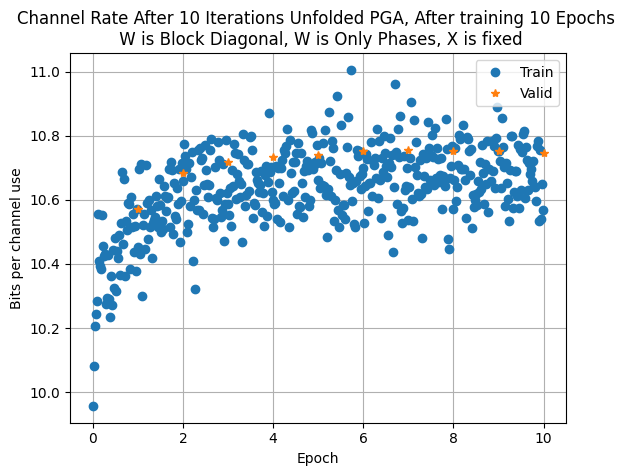

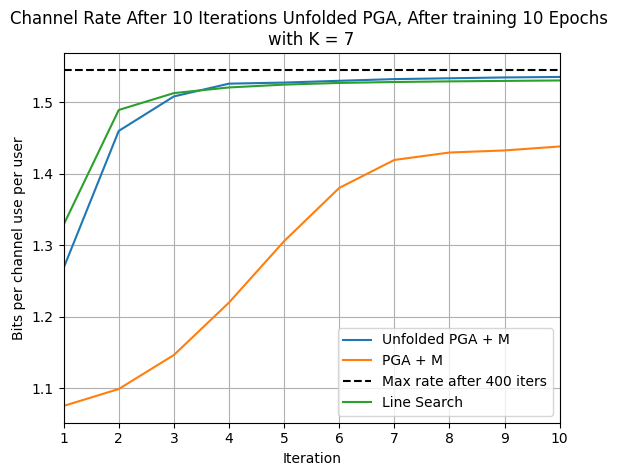

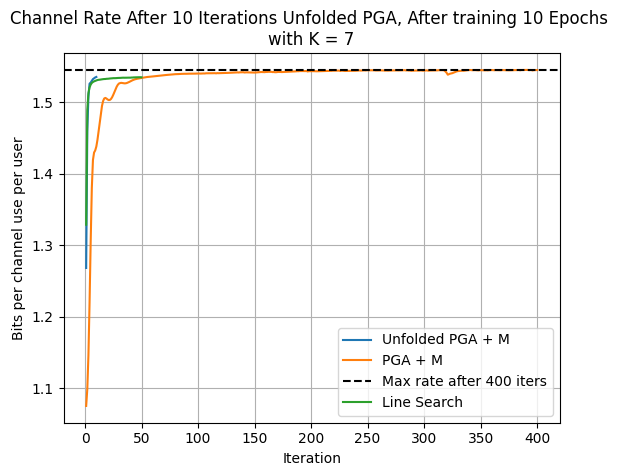

momentum: tensor([1.2681-6.6350e-09j, 1.4597+1.0071e-09j, 1.5079-1.2499e-09j,
        1.5257-1.2230e-08j, 1.5272-5.4732e-08j, 1.5298-3.5854e-09j,
        1.5321-4.3773e-08j, 1.5332-9.2787e-09j, 1.5344+7.0035e-08j,
        1.5351-1.2555e-07j], grad_fn=<DivBackward0>)
line search: tensor([1.3285, 1.4890, 1.5125, 1.5204, 1.5244, 1.5268, 1.5281, 1.5289, 1.5296,
        1.5302, 1.5308, 1.5311, 1.5313, 1.5315, 1.5318, 1.5320, 1.5322, 1.5323,
        1.5325, 1.5326, 1.5327, 1.5330, 1.5331, 1.5332, 1.5334, 1.5334, 1.5335,
        1.5336, 1.5337, 1.5338, 1.5338, 1.5339, 1.5340, 1.5341, 1.5340, 1.5340,
        1.5341, 1.5341, 1.5341, 1.5341, 1.5343, 1.5343, 1.5345, 1.5345, 1.5346,
        1.5346, 1.5347, 1.5347, 1.5348, 1.5346])
pga 400: tensor([1.0752+2.2963e-10j, 1.0988-4.2972e-09j, 1.1463-2.1294e-09j,
        1.2196-2.2811e-09j, 1.3055+2.2206e-11j, 1.3799+4.8651e-09j,
        1.4191-6.5209e-10j, 1.4295-8.7494e-10j, 1.4324-4.3744e-10j,
        1.4379-1.8891e-10j, 1.4473+2.8151e-09j, 1.4594-2.9

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


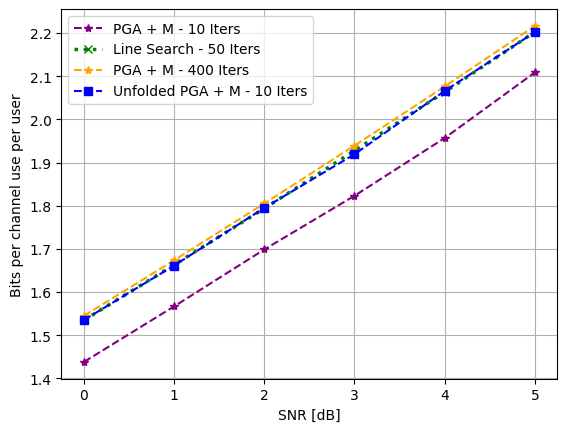

line search max:  [tensor(1.5346), tensor(1.6631), tensor(1.7936), tensor(1.9275), tensor(2.0636), tensor(2.2027)]
pga 400 max:  [tensor(1.5447+3.4069e-07j), tensor(1.6735-1.5502e-07j), tensor(1.8052-2.8795e-07j), tensor(1.9392+1.2541e-07j), tensor(2.0763+8.8121e-08j), tensor(2.2166+7.1755e-08j)]
pga 10 max:  [tensor(1.4379-1.8891e-10j), tensor(1.5666-2.0774e-09j), tensor(1.6985+2.3129e-09j), tensor(1.8229-2.6401e-09j), tensor(1.9568+5.3680e-09j), tensor(2.1088-2.2604e-11j)]
momentum max:  [tensor(1.5351-1.2555e-07j, grad_fn=<DivBackward0>), tensor(1.6613-2.3408e-08j, grad_fn=<DivBackward0>), tensor(1.7949-2.1572e-08j, grad_fn=<DivBackward0>), tensor(1.9192+4.8629e-09j, grad_fn=<DivBackward0>), tensor(2.0659-1.3706e-08j, grad_fn=<DivBackward0>), tensor(2.2022-2.0214e-08j, grad_fn=<DivBackward0>)]


In [ ]:
range_snr = range(0, 6)
line_search_max = [0 for _ in range_snr]
pga_400_max = [0 for _ in range_snr]
pga_10_max = [0 for _ in range_snr]
unfolded_max = [0 for _ in range_snr]
momentum_max = [0 for _ in range_snr]
for SNR in range_snr:
    init_time = time.time()
    print("SNR =",SNR)
    device, n_0, p_s, B, K, P, N, M, L, T, snr, T_opt, A, Ik, Im,D, J, epochs, W_is_block_diag, W_is_phase_only, X_is_variable,\
        train_size, batch_size, pga_iters, optimizer_learning_rate= set_general_params(J=10, epochs=10, batch_size=20,
                            T=5,K=7,P=4,L=2,N=2,B=2,train_size = 900, pga_iters = 400,optimizer_learning_rate=0.005, n_0 = 10**(-0.1*SNR))
    H_train,H_valid,X,W = gen_data(seed = 1, train_size = train_size, valid_size = 100)
    mat_file_path = r"/content/H_1000_2_8_7.mat" # Using an external data, generated in advance.
    H = sio.loadmat(mat_file_path)['H']
    H = H.transpose(0,3,2,1)  # Reordering the data to be (Sample number, B, M, K)

    # Dividing to train and validation:
    H_train = torch.tensor(H[-train_size:], dtype=torch.complex64)
    H_valid = torch.tensor(H[:H_valid.shape[0]], dtype=torch.complex64)
    H_train,H_valid,X,W = H_train.to(device),H_valid.to(device),X.to(device),W.to(device)

    # Creating benchmarks:
    # Linesearch benchmark:
    grid_line = torch.cat((torch.linspace(0.1, 1, 8),torch.linspace(1.5, 9.5, 17))).to(device)
    Rs_line_search, _ = line_search(H_valid, X, W, A, p_s, n_0, grid_line, line_search_iters = 50)

    # PGA + M benchmark:
    # Choosing the best Mu and Beta from a finite grid:
    grid_mu =  torch.cat((torch.linspace(0.05, 1, 5),torch.linspace(1.5, 5.5, 5))).to(device)
    grid_beta = torch.linspace(0.9, 0.99, 2).to(device)
    best_mu, best_beta, best_R_mom = mu_and_beta_search(H_valid, W, X, A, p_s, n_0, constant_search_iters=pga_iters,
                                                        grid_mu=grid_mu, grid_beta=grid_beta)
    # Extracting the results from the chosen best Mu and Beta
    Rs_pga_400, _,_ = run_PGA_Momentum(PGA_Mu_init=best_mu, beta=best_beta, pga_iters=pga_iters,H_valid = H_valid,W=W,X=X,A=A, p_s= p_s, n_0=n_0)
    Rs_pga_10,_,_ = run_PGA_Momentum(PGA_Mu_init=best_mu,beta=best_beta, pga_iters=J,H_valid = H_valid,W=W,X=X,A=A, p_s= p_s, n_0=n_0)

    # Start training prodecure:
    momentum_model, mom_train_rates,mom_validation_rates = train_momentum(H_train,H_valid, X,
                                                      W, A, p_s=p_s, n_0=n_0, J=J,Mu_X_init=1.5, Mu_W_init=best_mu,
                                                      optimizer_learning_rate=optimizer_learning_rate,
                                                      epochs=epochs,train_size = train_size,
                                                      batch_size = batch_size, betas_init = best_beta)
    # Documenting the results:
    line_search_max[SNR] = Rs_line_search[-1]/K
    pga_400_max[SNR] = Rs_pga_400[-1]/K
    pga_10_max[SNR] = Rs_pga_10[-1]/K
    momentum_max[SNR] = mom_validation_rates[-1][-1]/K
    # For the first run, print the results for inspection:
    if SNR==0:
        plot_learning_curve(mom_train_rates, mom_validation_rates)
        plot_comparison(J, mom_validation_rates[-1]/K, pga_iters, Rs_pga_400/K)
        plt.plot(range(1,51), Rs_line_search.cpu().detach().numpy()/K, label='Line Search')
        plt.xlim(1,J)
        plt.legend()
        plt.show()
        plot_comparison_full(J, mom_validation_rates[-1]/K, pga_iters, Rs_pga_400/K)
        plt.plot(range(1,51), Rs_line_search.cpu().detach().numpy()/K, label='Line Search')
        plt.legend()
        plt.show()
        print("momentum:", mom_validation_rates[-1]/K)
        print("line search:", Rs_line_search/K)
        print("pga 400:", Rs_pga_400/K)
    print("SNR time:", round(time.time()-init_time,2),"seconds")

# after running for different values of SNR, creating a plot, and printing the results:
plt.figure()
plt.plot(range_snr,torch.tensor(pga_10_max).cpu(), '--*',color="purple",label= 'PGA + M - 10 Iters')
plt.plot(range_snr,torch.tensor(line_search_max).cpu(), 'g:x',label= 'Line Search - 50 Iters', linewidth=2.5)
plt.plot(range_snr,torch.tensor(pga_400_max).cpu(),'--*' ,color="orange",label= 'PGA + M - 400 Iters')
plt.plot(range_snr,torch.tensor(momentum_max).cpu(), 'b--s',label= 'Unfolded PGA + M - 10 Iters')
plt.grid()
plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel("Bits per channel use per user")
plt.show()
print("line search max: ", line_search_max)
print("pga 400 max: ", pga_400_max)
print("pga 10 max: ", pga_10_max)
print("momentum max: ", momentum_max)
